In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P
from mppi.Utilities import Tools
from mppi.Utilities import Constants as Const
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis'


In [3]:
omp = 1
mpi = 16 #4
partition = 'all12h' # debug, slownodes, all12h, fastnode, smallnode
memory = '125000' # 60000 / 125000 / 180000
nodelist = 'wnode08'
ntasks_per_node = '%s'%int(mpi/2)
nodes = 3
sbatch_options = [
    '--partition=%s'%partition,
    '--mem=%s'%memory,
    '--nodes=%s'%nodes,
    #'--ntasks-per-node=%s'%ntasks_per_node,
    #,'--nodelist=%s'%nodelist
    ] 

In [5]:
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo')
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'yambo',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h', '--mem=125000', '--nodes=3'],
 'activate_BeeOND': True,
 'verbose': True}

# GW convergence analysis of the Germanene

We compute the GW corrections of the DFT band structure of the Germanene. 

We discuss the convergene procedure using various approximations of the self-energy.

We have performed various preliminary tests in particular:

__Parallelization strategy__

We set the SE_ROLEs as 'b.qp.q' and we observe that (with 16 mpi)
* for 6,6,1 kpoints the highest performance are achieved with '16.1.1'
* for 12,12,1 kpoints the only working configuration is '16.1.1' (reasons are to be checked further...)

__Random integration method (RIM) and Coulomb potential cutoff__

.........

## Hartree-Fock convergence analysis 

At the Hartree-Fock (HF) level the self energy is limited to the exchange part $\Sigma_x$ written in term of the
bare Coulomb potential.

The diagonal matrix elements of $\Sigma_x$ on the KS states are written as
$$
\langle nk|\Sigma_x|nk \rangle = -\sum_{n'}\int_{BZ}dq\sum_G \frac{4\pi}{|q+G|^2}
|\rho_{nn'}(k,q,G|^2f_{n',k-q}
$$
The sum over $n'$ il limited to the full bands due the $f_{n'}$ factor and so the self energy in this
approximation scheme depends on the $k$-points sampling in the BZ (q sum) and on the cutoff of the plane wave
expansion of the KS states.

We study the converge of the direct gap at the $K$ point in function of the number of plane wave of the exchange (EXXRLvcs variable in Yambo).
The highest value of this variable is given by the cutoff of the density matrix in QuantumESPRESSO, that in turn is
4 times the cutoff on the KS wave functions ($90*4=360$ Ry in the present analysis).

We also study the convergence of the gap in function of the $k$-points sampling of the BZ.

In [6]:
#kvalues = [12,18,24,30,36,42,48,54,60,66,78]
kvalues = [78]

test_set = {}
for k in kvalues:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_60.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s'%k
    dft_data = P.PwParser(os.path.join(source_dir,'data-file-schema.xml'),verbose=False)
    test_set[k] = {'source_dir' : source_dir,
                   'run_dir' :  run_dir,
                    'K_index' : len(dft_data.kpoints)}
#test_set

In [7]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

We build the input for HF analysis including the random integration method (RIM) for the small $q$ component of the Coulomb potential
and the cutoff of the Coulomb potential in the off plane direction. 

The z dimension of the simulation box is 
* $7.643*8 = 61.44$ au and we set the cutoff to 60 au
* $7.643*4 = 30.572$ au and we set the cutoff to 30 au

In [8]:
cut_z = 30 # 60 # au, slightly smaller than the cell, in agreement with the Yambo tutorial page
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

### Analysis of the q-points sampling and of the and of the $G$-points expansion of the exchange term

First, we perform a convergence test on the EXXRLvsc parameter at k=18 sampling, than we study
the convergence of the $q$-point sampling

In [9]:
k_sel = 18
Tools.build_SAVE(test_set[k_sel]['source_dir'],test_set[k_sel]['run_dir'],command='p2y')

SAVE folder already present in GW_HF_analysis/kpoints_18. No operations performed.


In [10]:
EXXRLvcs = [10,20,40,60,80] #[20,40,60,80,100]

study = D.Dataset(run_dir=test_set[k_sel]['run_dir'],num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput(args='yambo -r -x -V all',folder=test_set[k_sel]['run_dir'])
inp.set_extendOut()
K_index = test_set[k_sel]['K_index']
inp.set_kRange(K_index,K_index)
inp.set_bandRange(start_band,stop_band)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
inp['variables']['SE_CPU'] = '%s.1.1'%mpi
inp['variables']['SE_ROLEs'] = 'b.qp.q'

for ex in EXXRLvcs:
    idd = {'kpoints':k_sel,'exxrlvcs':ex,'cutbox':cut_z,'randQ':RandQpts,'randG':RandGvec}
    inp['variables']['EXXRLvcs'] = [ex,'Ry']
    study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 1 parallel tasks


In [11]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0], [1], [2], [3], [4]] 

Run the task [0] 
run command: mpirun -np 16 yambo -F cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000.in -J cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000 -C cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000
slurm submit:  cd GW_HF_analysis/kpoints_18 ; sbatch job_cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000.sh
computation cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000 is running...
computation cutbox_30-exxrlvcs_10-kpoints_18-randG_100-randQ_1000000 ended
Run performed in 02m-49s
Task [0] ended 
 
Run the task [1] 
Skip the run of cutbox_30-exxrlvcs_20-kpoints_18-randG_100-randQ_1000000
Task [1] ended 
 
Run the task [2] 
Skip the run of cutbox_30-exxrlvcs_40-kpoints_18-randG_100-randQ_1000000
Task [2] ended 
 
Run the task [3] 
Skip the run of cutbox_30-exxrlvcs_60-kpoints_18-randG_100-randQ_1000000
Task [3] ended 
 
Run the task [4] 
run command

In [12]:
gap = [results[ind].data.get_gap(k_full=test_set[k_sel]['K_index'],band_full=start_band,verbose=False) for ind in range(len(EXXRLvcs))]
gap

[0.847812, 0.849063, 0.8491869999999999, 0.8491879999999999, 0.849189]

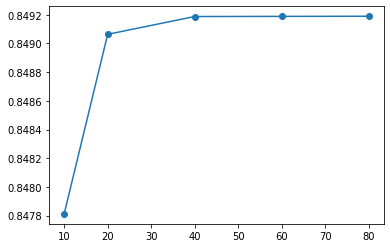

In [13]:
plt.plot(EXXRLvcs,gap)
plt.scatter(EXXRLvcs,gap)

We choose EXXRRLvcs = 60 Ry as converged value and analyze the convergence of the $q$-points sampling

In [9]:
EXXRLvcs_conv = 40 # Ry

In [10]:
study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in test_set:
    Tools.build_SAVE(test_set[k]['source_dir'],test_set[k]['run_dir'],command='p2y')
    inp = I.YamboInput(args='yambo -r -x -V all',folder=test_set[k]['run_dir'])
    inp.set_extendOut()
    K_index = test_set[k]['K_index']
    inp.set_kRange(K_index,K_index)
    inp.set_bandRange(start_band,stop_band)
    inp['variables']['EXXRLvcs'] = [EXXRLvcs_conv,'Ry']
    inp['variables']['RandQpts'] = [RandQpts,'']
    inp['variables']['RandGvec'] = [RandGvec,'']
    inp['variables']['CUTGeo'] = 'box z'
    inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']
    inp['variables']['SE_CPU'] = '%s.1.1'%mpi
    inp['variables']['SE_ROLEs'] = 'b.qp.q'
    
    idd = {'kpoints':k,'exxrlvcs':EXXRLvcs_conv,'cutbox':cut_z,'randQ':RandQpts,'randG':RandGvec}
    study.append_run(id=idd,input=inp,runner=code,run_dir=test_set[k]['run_dir'])

Initialize a Dataset with 1 parallel tasks
SAVE folder already present in GW_HF_analysis/kpoints_78. No operations performed.


In [11]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_HF_analysis/kpoints_78/job_cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.out
delete folder: GW_HF_analysis/kpoints_78/cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000
run command: mpirun -np 16 yambo -F cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.in -J cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 -C cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000
slurm submit:  cd GW_HF_analysis/kpoints_78 ; sbatch job_cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000.sh
computation cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 is running...
computation cutbox_30-exxrlvcs_40-kpoints_78-randG_100-randQ_1000000 ended

        There are no o-* files.
        Maybe you have performed a ypp computation or wait_end_run and/or
        the dry_run option are active?
        Otherwise a possible error has occured during the computation
   

In [35]:
gap = []
for k in kvalues:
    r = study.fetch_results(id={'kpoints':k})[0]
    gap.append(r.data.get_gap(k_full=test_set[k]['K_index'],band_full=start_band,verbose=False))
gap

[1.162207,
 0.8491869999999999,
 0.7013119999999999,
 0.615127,
 0.559527,
 0.519778,
 0.490761,
 0.468854,
 0.45126199999999994,
 0.43705900000000003]

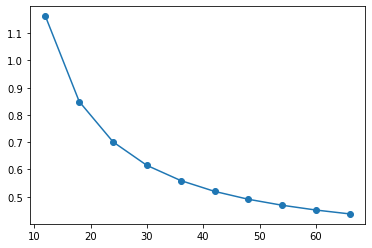

In [36]:
plt.plot(kvalues,gap)
plt.scatter(kvalues,gap)

In [37]:
from scipy.optimize import curve_fit

In [38]:
x = np.array(kvalues)
y = np.array(gap)

In [39]:
def exp(t,a,b,c):
    return a*np.exp(b*t)+c

In [40]:
p0 = [1,-0.1,0.5]
pars,pcov = curve_fit(exp,x,y,p0=p0)
pars

array([ 1.89850688, -0.08284485,  0.44739332])

In [46]:
x_ext = np.linspace(20,80)

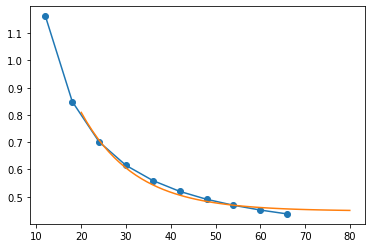

In [47]:
plt.plot(kvalues,gap)
plt.scatter(kvalues,gap)
plt.plot(x_ext,exp(x_ext,*pars))

## COHSEX convergence analysis 

We discuss different approximations for the self energy $\Sigma = G_0 W$. 
The evaluation of $W$ passes through:
$$
\chi = \chi_0 + \chi_0(v_H+f_{xc})\chi \\
W = v+v\chi v
$$

In the COHSEX one considers only the static contribution of the response $\chi(\omega=0)$ and we also limit our analysis to the Hartree kernel, so that $f_{xc}=0$ (RPA approximations).

In this case (without empties) G0 still depends only from the number of kpoints and from the EXXRLvcs parameter. Moreover we introduce also a non trivial W potential and two more parameters come into the play. These are the cut of in the plane wave expansion of the response function for the construction of W (NGsBlkXs) and the number of empty bands used to write the Lehmann representation of $\chi_0$ (BndsRnXs).

In [12]:
run_dir = 'GW_HF_analysis/kpoints_18'

In [18]:
inp = I.YamboInput(args='yambo -k hartee -dyson n -gw0 c -V qp',folder=run_dir)
inp

{'args': 'yambo -k hartee -dyson n -gw0 c -V qp',
 'folder': 'GW_HF_analysis/kpoints_18',
 'filename': 'yambo.in',
 'arguments': ['em1s', 'gw0', 'HF_and_locXC', 'cohsex'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'SE_Threads': [0.0, ''],
  'EXXRLvcs': [178169.0, 'RL'],
  'VXCRLvcs': [178169.0, 'RL'],
  'XfnQP_INTERP_NN': [1.0, ''],
  'XfnQP_INTERP_shells': [20.0, ''],
  'XfnQP_Wv_E': [0.0, 'eV'],
  'XfnQP_Wv_dos': [0.0, 'eV'],
  'XfnQP_Wc_E': [0.0, 'eV'],
  'XfnQP_Wc_dos': [0.0, 'eV'],
  'NGsBlkXs': [1.0, 'RL'],
  'GfnQP_INTERP_NN': [1.0, ''],
  'GfnQP_INTERP_shells': [20.0, ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'GWoIter': [0.0, ''],
  'GWIter': [0.0, ''],
  'SCEtresh': [0.01, 'eV'],
  'Chimod': 'HARTREE',
  'XfnQPdb': 'none',
  'XfnQP_DbGd_INTERP_mode': 'NN',
  'XTermKind': 'none',
  'GfnQPdb': 'none',
  'GfnQP_DbGd_INTERP_mode': 'NN',
  'XfnQP_Z': [(1+0j), ''],
  'GfnQ